In [58]:
### mostly for Nhits and dPhi plots in paper for CSC analysis in the combination paper


import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import  make_datacard_2sig, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [59]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'

ctau = '1000'
masses = ['7', '15','40','55']
ntupler_version = 'V1p17/'
analyzer_version = "/v1/v167/"
decay = 'dddd'
ct = 1000

prod = ['ggH', 'VBFH','ZH', 'WH', 'ttH','ggZH']

ntupler_version = 'V1p17/'
mc_path = {}
analyzer_version = 'v1/v167/'
mc_central_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
analyzer_version = 'v2/v167/'
mc_private_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'


for p in prod:
    for m in masses:
        key = 'MC_'+p + '_'+m+'_'+str(ct)
        if p == 'ggH':
            fpath[key] = mc_central_path+p+'_HToSSTodddd_MH-125_MS-'+m+'_ctau-'+str(ct)+'_137000pb_weighted.root'
        else:
            if 'ggH' in p or 'ttH' in p: fpath[key] = mc_private_path+p+'_HToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            elif p == 'VBFH' or p=='ZH' or p == 'WH': fpath[key] = mc_private_path+p+'ToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            elif 'ggZH' in p:fpath[key] = mc_private_path+'ZHToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
        if not os.path.exists(fpath[key]):print('FILE NOT FOUND',key, fpath[key])

                


analyzer_version = "/v5/v167/"
data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
fpath['data'] = data_path +'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print(k, "NEvents",NEvents[k])


root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']

MC_ggH_7_1000 NEvents 106227390.0
MC_ggH_15_1000 NEvents 102585040.0
MC_ggH_40_1000 NEvents 106752310.0
MC_ggH_55_1000 NEvents 104310510.0
MC_VBFH_7_1000 NEvents 517427.94
MC_VBFH_15_1000 NEvents 579324.2
MC_VBFH_40_1000 NEvents 771304.4
MC_VBFH_55_1000 NEvents 577754.06
MC_ZH_7_1000 NEvents 328973.38
MC_ZH_15_1000 NEvents 333179.34
MC_ZH_40_1000 NEvents 150467.9
MC_ZH_55_1000 NEvents 157271.38
MC_WH_7_1000 NEvents 278592.3
MC_WH_15_1000 NEvents 278505.12
MC_WH_40_1000 NEvents 280029.44
MC_WH_55_1000 NEvents 279076.75
MC_ttH_7_1000 NEvents 104786.51
MC_ttH_15_1000 NEvents 104781.12
MC_ttH_40_1000 NEvents 101989.2
MC_ttH_55_1000 NEvents 102549.61
MC_ggZH_7_1000 NEvents 328973.38
MC_ggZH_15_1000 NEvents 333179.34
MC_ggZH_40_1000 NEvents 150467.9
MC_ggZH_55_1000 NEvents 157271.38
data NEvents 22763250.0


# nCsc with different hit vetoing

In [60]:
%%time


ggZH_weight = {}
nCsc = {}
dphiMet_cluster = {}
weight = {}
overlap = {}
higgsPt ={}
higgsEta = {}
for k in list(tree.keys())+['data_intime','data_oot','data_unblind']:
    if k == 'data':continue
    
    
#     if not 'unblind' in k:continue
    
    if 'data' in k: T = tree['data']
    else: T = tree[k]
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)
    cluster_index = ''
    ########### SELECTION: CLUSTERS ############

    sel_rechitcluster = np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.0
    if 'oot' in k:
        sel = [T.array('cscRechitCluster'+cluster_index+'TimeTotal') < -12.5,]
    elif k == 'data_intime':
        sel = [np.logical_and(T.array('cscRechitCluster'+cluster_index+'Size') < 80,\
                              np.logical_and(T.array('cscRechitCluster'+cluster_index+'TimeTotal') > -5.0, T.array('cscRechitCluster'+cluster_index+'TimeTotal') < 12.5)),]
    else: #unblind data
        sel = [np.logical_and(T.array('cscRechitCluster'+cluster_index+'TimeTotal') > -5.0, T.array('cscRechitCluster'+cluster_index+'TimeTotal') < 12.5),]
    sel+=[
        T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10,
        T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0,
         T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0,
        T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0,
        np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.0,
         T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20,
    ]
    for ele in sel:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, ele)

        
        
    cond2 = np.logical_and(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==2, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.6)
    cond3 = np.logical_and(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==3, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.6)
    cond4 = np.logical_and(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==4, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.8)
    cond1 = np.logical_and(T.array('cscRechitCluster'+cluster_index+'NStation10')==1, np.logical_or(np.logical_or(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(T.array('cscRechitCluster'+cluster_index+'NStation10') > 1, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.9)
    cut_based_id = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    sel_rechitcluster = np.logical_and(sel_rechitcluster, cut_based_id)
    ###### double cluster requirement #####
    
    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    if 'data' in k: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
    else: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))
        
    sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId'))))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    
    cut = 5
    station = (T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations
    if not 'data' in k: 
        sel_dtcluster = np.logical_and(sel_dtcluster, (T.array('dtRechitClusterSize')+T.array('dtRechitClusterNoiseHit')) >= 50)
    else: sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterSize') >= 50)

    # cosmic muon veto 
    sel_cosmic = np.logical_and(T.array('dtRechitClusterNOppositeSegStation1')>0, T.array('dtRechitClusterNOppositeSegStation2')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation3')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation4')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation1')+T.array('dtRechitClusterNOppositeSegStation2')+\
                               T.array('dtRechitClusterNOppositeSegStation3')+T.array('dtRechitClusterNOppositeSegStation4')>=6)
    nstation = (T.array('dtRechitClusterNSegmentStation1')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>1).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>1).astype(int)
    
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(nstation>=3, sel_cosmic)))
    ###### end of double cluster requirement #####
    
    
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()

    sel_ev   = np.logical_and(T.array('metEENoise') > 200 ,T.array('METNoMuTrigger'))
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_ev = np.logical_and(sel_ev, (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()>=1)
    


    ########################
    # remove overlap with double tag category
    cscEta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev]
    cscPhi = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev]
    dtEta = T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev]
    dtPhi = T.array('dtRechitCluster' + cluster_index + 'Phi')[sel_dtcluster][sel_ev]
    # csc-csc
    cond = deltaR(cscEta.min(),cscEta.max(),cscPhi.min(),cscPhi.max())<2
    cat0 = np.logical_and(cond, sel_csccluster[sel_ev].sum()==2)
    # dt-csc
    cond = deltaR(cscEta.min(),dtEta.min(),cscPhi.min(),dtPhi.min())<2.5
    cat2 = np.logical_and(cond,  np.logical_and(sel_csccluster[sel_ev].sum()==1,sel_dtcluster[sel_ev].sum()==1))
    # dt-dt
    cat1 = sel_dtcluster[sel_ev].sum()==2
    # incorporate the removal of overlap in the bdt_sel variable
    overlap[k] =  np.logical_not(np.logical_or(cat0, np.logical_or(cat1, cat2)))
    
#     sel_ev = np.logical_and(sel_ev, overlap[k])
#     print(np.count_nonzero(sel_rechitcluster.sum()[sel_ev][overlap[k]]>2))
#     print(np.count_nonzero(sel_rechitcluster.sum()[sel_ev][overlap[k]]==2))
#     print(np.count_nonzero(sel_rechitcluster.sum()[sel_ev][overlap[k]]==1))
    ####### fill nRechits and dPhi variables ######
    nCsc[k] =  T.array('cscRechitCluster'+cluster_index+'Size')[sel_rechitcluster][sel_ev][overlap[k]][:,0]
    dphiMet_cluster[k] =  T.array('cscRechitCluster'+cluster_index+'MetEENoise_dPhi')[sel_rechitcluster][sel_ev][overlap[k]][:,0]
    
    
    higgsPt[k] = T.array('gHiggsPt')[sel_ev][overlap[k]]
    higgsEta[k] = T.array('gHiggsEta')[sel_ev][overlap[k]]
    ggZH_weight[k]=h_reweight.values[np.argmax(h_reweight.edges[0]>higgsPt[k][:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>np.abs(higgsEta[k])[:,None],axis=1)-1]
    



    if not 'data' in k:
        if 'ggH' in k: weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev][overlap[k]]
        else:weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][overlap[k]]
        if 'ggZH' in k: weight[k] *= ggZH_weight[k]
    else: weight[k] = dphiMet_cluster[k]*0.0 +1.0



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in less


CPU times: user 1min 6s, sys: 4.29 s, total: 1min 11s
Wall time: 1min 30s


In [110]:
std_color_list[4]

6

In [111]:
#color and style for signal

line_color = [2, 801, 870, 6]
line_style = [7, 9, 5, 2]

# unblinded result plots (2bin)

0 7
1 15
2 40
3 55
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/result_csc//v5/v167//unblind//Nrechits_2bin_dddd_paper.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/result_csc//v5/v167//unblind//Nrechits_2bin_dddd_paper.C has been generated
Info in

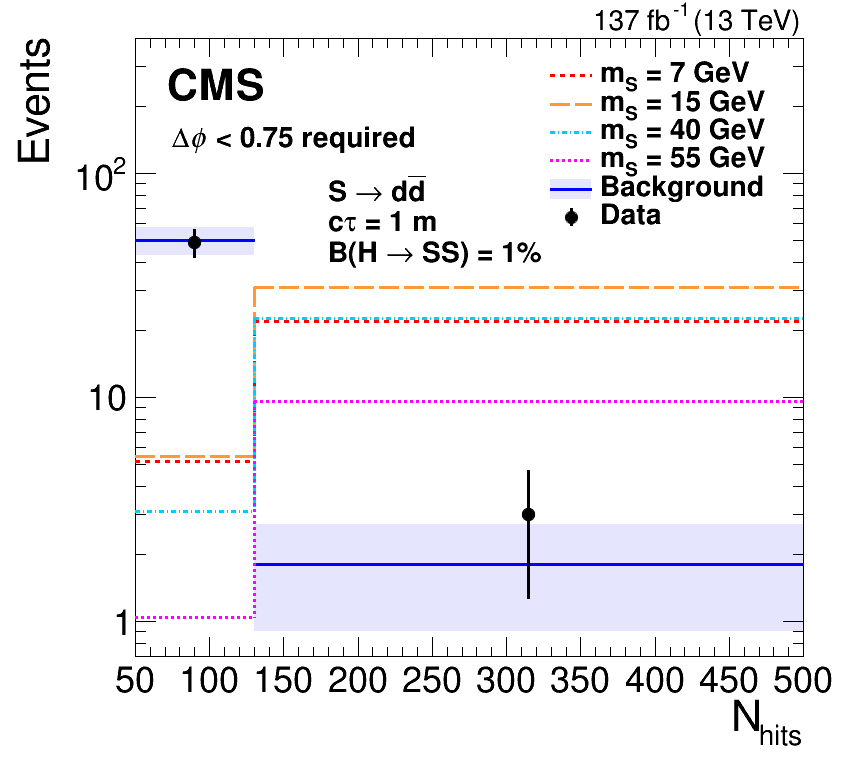

In [113]:
import os
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 0
if index == 1:cut_index = 0
elif index == 0:cut_index = 1
unblind = 1
nrechit_cut = 130
dphi_cut = 0.75


var = [nCsc, dphiMet_cluster]
weights = [weight, weight ]
xaxis = [ 'N_{hits}', '#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster) [radians]']


name = ['Nrechits','dphi_cluster_met']
ymax = 500
binning = [[50,130,ymax],[0,0.75,3.14]]


if index == 0: leg = rt.TLegend(0.64,0.70,0.92,0.92)
else: leg = rt.TLegend(0.60,0.70,0.90,0.92)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}

# plot signal
for i, m in enumerate(masses):
    array = []
    weight_temp = []
    for p in prod:
        k = 'MC_'+p + '_'+m+'_'+str(ct)
        
        overflow = np.abs(var[index][k].flatten())
        if index == 0: overflow[overflow>=ymax]=ymax-1
        if cut_index == 0:
            array += list(overflow[var[cut_index][k].flatten()>=nrechit_cut])
            weight_temp += list(0.01*weights[index][k][var[cut_index][k].flatten()>=nrechit_cut].flatten())
        else: 
            array += list(overflow[np.abs(var[cut_index][k].flatten())<dphi_cut])
            weight_temp += list(0.01*weights[index][k][ np.abs(var[cut_index][k])<dphi_cut].flatten())
    h[m] = create_TH1D(array, axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = weight_temp, bin_list = True)
    print(i,m)
    h[m].SetLineColor(line_color[i])
    h[m].SetLineStyle(line_style[i])

    h[m].Scale(corrections)    

    leg.AddEntry(h[m],"m_{S} = "+m+" GeV",'L')

# plot observation
if cut_index == 0:h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][var[cut_index]['data_unblind']>=nrechit_cut].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index], bin_list = True)

else:h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.abs(var[cut_index]['data_unblind'])<dphi_cut].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index], bin_list = True)



# plot bkg only fit
if index == 0:
    bkg = [55, 150]
    w = [50.2, 1.8] #bin C/D
    h['bkg'] = create_TH1D(bkg,  axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = w, bin_list = True)
    h['bkg'].SetBinError(1, 7.2) #bin C error
    h['bkg'].SetBinError(2,0.9) #SR
else:#dphi
    bkg = [0.05, 1]
    w = [1.8, 4.2] # bin D/A
    h['bkg'] = create_TH1D(np.array(bkg),  axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = np.array(w), bin_list = True)


    h['bkg'].SetBinError(1,0.9) #SR error
    h['bkg'].SetBinError(2, 1.9) #bin A error
h['bkg'].SetLineWidth(3)
h['bkg'].SetLineColor(4)

h['bkg_err'] = h['bkg'].Clone()


leg.AddEntry(h['bkg_err'], 'Background')


h['data_unblind'].SetLineWidth(3)


h['data_unblind'].SetLineColor(1)
h['data_unblind'].SetMarkerStyle(20)
h['data_unblind'].SetMarkerSize(1.5)
if index == 1: h['data_unblind'].GetYaxis().SetRangeUser(0.5,400)
else: h['data_unblind'].GetYaxis().SetRangeUser(0.7,400)
if index == 1: h['data_unblind'].GetXaxis().SetTitleOffset(0.99)


leg.AddEntry(h['data_unblind'], 'Data','EP')
h['data_unblind'].Draw('esamex0')

h['bkg_err'].SetLineWidth(3)

h['bkg_err'].SetLineColor(4)
# h['bkg_err'].SetFillStyle(3002)
h['bkg_err'].SetFillColorAlpha(4,0.1)

h['bkg_err'].Draw('l E2 same')
h['bkg'].SetBinError(1, 0.001)
h['bkg'].SetBinError(2,0.001) #SR
h['bkg'].Draw('L same')






for k in masses:
    h[k].SetLineWidth(3)
    h[k].Draw(' hist same')

h['data_unblind'].Draw('esamex0')


latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)

latex = rt.TLatex()
latex.SetTextSize(0.04)
if index == 1:
    x = 1.8
    if decay == 'dddd': latex.DrawLatex(x,24,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,24, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,24, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(x,17.5, "c#tau = 1 m")
    latex.DrawLatex(x,12, "B(H #rightarrow SS) = 1%")
    latex.DrawLatex(0.18, 90,'N_{hits} #geq 130 required')



else:
    x = 180
    latex.DrawLatex(75,130, '#Delta#it{#phi} < 0.75 required')
    latex.DrawLatex(x,40, "B(H #rightarrow SS) = 1%")
    latex.DrawLatex(x,55, "c#tau = 1 m")

    if decay == 'dddd': latex.DrawLatex(x,75,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,55, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,55, "S #rightarrow #tau^{+}#tau^{-}")

        
# l.SetLineWidth(2)
# l.Draw()    


c.SetRightMargin(0.05)
c.SetBottomMargin(0.15)



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 0
CMS_lumi.extraText   = "Preliminary"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05
CMS_lumi.cmsTextSize      = 1.2


CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/result_csc/'+analyzer_version
if unblind:outDir += '/unblind/'
if not os.path.isdir(outDir):os.makedirs(outDir)

if CMS_lumi.writeExtraText:
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_pas_paper.png')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_pas_paper.C')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_pas_paper.pdf')
else:
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_paper.png')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_paper.C')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_paper.pdf')

# OOT control region (motivate cuts in search strategy section)

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc//v5/v167//unblind//ootdata_Nrechits_dddd_paper.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc//v5/v167//unblind//ootdata_Nrechits_dddd_paper.C has been generat

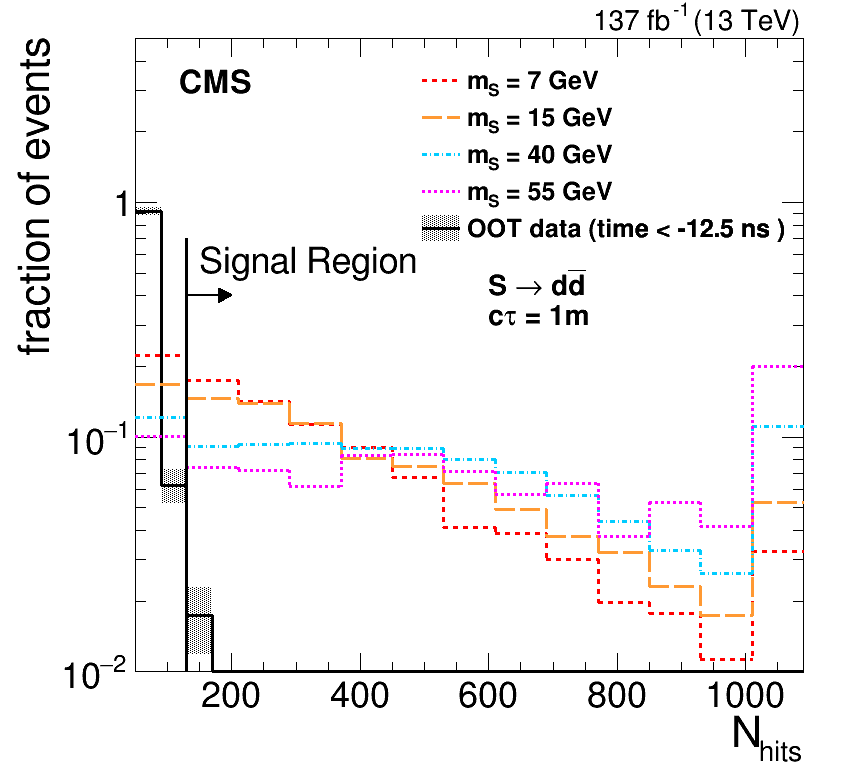

In [143]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


corrections = 0.90332048232



index = 0
if index == 1:
    cut_index = 0
elif index == 0:
    cut_index = 1

nrechit_cut = 0
dphi_cut = 100



var = [nCsc, dphiMet_cluster]
weights = [weight, weight ]
xaxis = [ 'N_{hits}', '#Delta#phi(p_{T}^{miss}, cluster)']
xaxis = [ 'N_{hits}','#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']


name = ['Nrechits','dphi_cluster_met']
ymax = 1090
# binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[25,50,ymax],[10,0,3.14]]
binning = [list(np.arange(50,1050+80,80)),[10,0,3.14]]



leg = rt.TLegend(0.49,0.68,0.74,0.92)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}

# plot signal
for i, m in enumerate(masses):
    array = []
    weight_temp = []
    for p in prod:
        k = 'MC_'+p + '_'+m+'_'+str(ct)

        overflow = np.abs(var[index][k].flatten())
        if index == 0: overflow[overflow>=ymax]=ymax-1
        if cut_index == 0:
            array += list(overflow[var[cut_index][k].flatten()>=nrechit_cut])
            weight_temp += list(0.01*weights[index][k][var[cut_index][k].flatten()>=nrechit_cut].flatten())
        else: 
            array += list(overflow[np.abs(var[cut_index][k].flatten())<dphi_cut])
            weight_temp += list(0.01*weights[index][k][ np.abs(var[cut_index][k])<dphi_cut].flatten())
            
    h[m] = create_TH1D(array, axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = weight_temp)
    h[m].SetLineColor(line_color[i])
    h[m].SetLineStyle(line_style[i])
    h[m].Scale(corrections)
    if index == 0: h[m].GetXaxis().SetNdivisions(5,5,0,False)
    
    leg.AddEntry(h[m],"m_{S} = "+m+" GeV",'L')

k = 'data_oot'
if cut_index == 0:
    h[k] = create_TH1D(np.abs(var[index][k][var[cut_index][k].flatten()>=nrechit_cut].flatten()),  axis_title=[xaxis[index], 'fraction of events'], binning = binning[index])
else:
    h[k] = create_TH1D(np.abs(var[index][k][np.abs(var[cut_index][k].flatten())<dphi_cut].flatten()),  axis_title=[xaxis[index], 'fraction of events'], binning = [26,50,ymax])
leg.AddEntry(h[k],'OOT data (time < -12.5 ns )')



for k,v in h.items():
    v.Scale(1./v.Integral())
    v.SetLineWidth(3)
    v.SetMaximum(5)
    v.SetMinimum(0.01)


temp = h['data_oot'].Clone()
temp.Draw('hist same')
h['data_oot'].SetFillStyle(3002)
h['data_oot'].SetFillColor(h['data_oot'].GetLineColor())
h['data_oot'].SetLineColor(h['data_oot'].GetLineColor())
h['data_oot'].Draw('E2 same')
for k in masses:h[k].Draw(' hist same')

latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)
if index == 0:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
    l = rt.TLine(130,0.01, 130, 0.7)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(130,0.4,200,0.4)
    latex.DrawLatex(150,0.5, "Signal Region")
else:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
    l = rt.TLine(0.75,0, 0.75, 2)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(0.5,0.9,0.75,0.9)
    latex.DrawLatex(0.2,1.4, "Signal")
    latex.DrawLatex(0.2,1, "Region")

latex = rt.TLatex()
latex.SetTextSize(0.04)
if index == 1:
    x = 1.8
    if decay == 'dddd': latex.DrawLatex(x,0.4,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,15, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,15, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(x,0.3, "c#tau = 1m")
#     latex.DrawLatex(x,0.2, "BR(h^{0} #rightarrow SS) = 1%")


elif index == 0:
    x = 600
    if decay == 'dddd': latex.DrawLatex(x,0.4,  "S #rightarrow d#bar{d}")
    latex.DrawLatex(x,0.3, "c#tau = 1m")
#     latex.DrawLatex(x,0.2, "BR(h^{0} #rightarrow SS) = 1%")

l.SetLineWidth(3)
l.Draw()    


c.SetRightMargin(0.05)


tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 0
# CMS_lumi.extraText   = 
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05

CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()

outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc/'+analyzer_version
if unblind:outDir += '/unblind/'
if not os.path.isdir(outDir):os.makedirs(outDir)

if CMS_lumi.writeExtraText:
    c.SaveAs(outDir+'/ootdata_'+name[index]+'_'+decay+'_pas_paper.png')
    c.SaveAs(outDir+'/ootdata_'+name[index]+'_'+decay+'_pas_paper.C')
    c.SaveAs(outDir+'/ootdata_'+name[index]+'_'+decay+'_pas_paper.pdf')
else:
    c.SaveAs(outDir+'/ootdata_'+name[index]+'_'+decay+'_paper.png')
    c.SaveAs(outDir+'/ootdata_'+name[index]+'_'+decay+'_paper.C')
    c.SaveAs(outDir+'/ootdata_'+name[index]+'_'+decay+'_paper.pdf')